In [261]:
# Vitaliy Stepanov
# Assignement 2
# Machine Learning

# This program uses the ID3 to train on date sets, generate a decision tree graph using dictionaries,
# displays tree graph, and predicts accuracy of unseen data.

import pandas as pd
import numpy as np

play_tennis = pd.read_csv("assets/playtennis.csv")
emails = pd.read_csv("assets/emails.csv")
vegetation = pd.read_csv("assets/vegetation.csv")
census = pd.read_csv("assets/census_training.csv")

# TYPE NAME OF CSV FILE TO TRAIN (census default)
example_df = census
pruning = 185 # peak accuracy for census is 185 pruning for 82.58% accuracy
test = True # set to True only for census

unique_attribute_values = {}

In [262]:
# removes columns with all distinct values to avoid overfitting
def remove_distinct_attributes(data_frame):
    for column in data_frame.columns:
        if len(data_frame[column].unique()) == len(data_frame[column]):
            del data_frame[column]
    return data_frame


example_df = remove_distinct_attributes(example_df)

features = example_df.columns.values.tolist()
target_feature = features[-1]
features.pop() # remove target feature
# add feature to dictionary as a key and unique values list as a value
for feature in features:
    unique_attribute_values[feature] = pd.value_counts(example_df[feature].values.ravel()).index

In [263]:
# returns uncertainity of an attribute by passing the data frame
def entropy(data_frame, attribute):
    attribute_value_counts = data_frame[attribute].value_counts()
    set_count = len(data_frame)
    entropy = 0
    for value_count in attribute_value_counts:
        probability = value_count/set_count
        entropy += -probability * np.log2(probability)
    return entropy

In [264]:
# returns information of gain of an attribute for it's impact on the target feature
def information_gain(data_frame, attribute):
    value_counts = data_frame[attribute].value_counts()
    target_feature_entropy = entropy(data_frame, target_feature)
    attribute_entropy = 0
    for value in value_counts.index:
        probability = value_counts[value]/len(data_frame)
        attribute_entropy += probability * entropy(data_frame[data_frame[attribute]==value], target_feature)
    return target_feature_entropy - attribute_entropy


In [265]:
# calculates best classifer to all attributes and returs most information gain attribute
def d_best(data_frame, attributes):
    entropy = -1
    best_gain = None
    for attribute in attributes:
        current_entropy = information_gain(data_frame, attribute)
        if current_entropy > entropy:
            entropy = current_entropy
            best_gain = attribute
    return best_gain


In [266]:
# builds and returns a dictionary decision tree
def build_tree(examples, attributes):
    pure = examples[target_feature].value_counts()
    majority_target_feature_value = pure.idxmax()
    # handles all 3 base cases: if all target values are pure or no more attributes to test and prunning
    if pure.size == 1 or len(attributes) == 0 or len(examples) <= pruning:
        return majority_target_feature_value
    else:
        best_feature = d_best(examples, attributes)
        root = {best_feature : {}} # dictionary of dictionaries
        # remove best_feature from attributes to not test again
        attributes = [i for i in attributes if i != best_feature]
        unique_values = unique_attribute_values[best_feature]
        for value in unique_values:
            # this selects all same value rows of an attribute
            partition_examples = examples.loc[examples[best_feature] == value]
            if partition_examples.empty:
                root[best_feature][value] = majority_target_feature_value
            else: # make a subtree by passing same value and remaining attributes
                root[best_feature][value] = build_tree(partition_examples, attributes)
        return root

decision_tree = build_tree(example_df, features)

In [267]:
import os
import pickle

# saves the model of the decision tree to prevent retraining
def serialize(decision_tree):
    folder_name = "model"
    file_name = "decision_tree"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    pickle.dump(decision_tree, open(os.path.join(folder_name, file_name), 'wb'), protocol=4)

serialize(decision_tree)

In [268]:
# prints accuracy of prediction on unseen data from the decision tree
def accuracy(test_df):
    correct = 0
    incorrect = 0
    for row in range(len(test_df)):
        find_leaf = decision_tree
        while isinstance(find_leaf, dict):   # keep iterating until find_leaf is not a dictionry but the answer
            attribute = next(iter(find_leaf))
            find_leaf = find_leaf[attribute][test_df[attribute][row]]  # traverse decision tree
        if test_df[target_feature][row] == find_leaf: # unseen target feature matches decision tree answer
            correct += 1
        else:
            incorrect += 1
    print(len(test_df), " instances")
    print(correct, "correct predictions")
    print(incorrect, "incorrect predictions")
    print((correct/len(test_df)) * 100, '% accuracy')

if test:
    test_df = pd.read_csv("assets/census_training_test.csv")
    accuracy(test_df)


15028  instances
12411 correct predictions
2617 incorrect predictions
82.58583976577056 % accuracy


In [269]:
# loads the saved model decision tree to prevent retraining
def deserialize(folder_name, file_name):
    return pickle.load(open(os.path.join(folder_name, file_name), 'rb'))


{'relationship': {'Husband': {'education': {'somecollege': {'occupation': {'Prof-specialty': {'native_country': {'United-States': {'age': {'age3': '>50K', 'age2': '<=50K', 'age1': '<=50K', 'age4': '>50K', 'age5': '>50K', 'age6': '<=50K', 'age7': '<=50K', 'age8': '<=50K', 'age9': '>50K'}}, 'Mexico': '<=50K', 'Philippines': '>50K', 'Germany': '>50K', 'Puerto-Rico': '>50K', 'Canada': '>50K', 'India': '>50K', 'El-Salvador': '<=50K', 'Cuba': '>50K', 'England': '>50K', 'Jamaica': '>50K', 'South': '>50K', 'Italy': '>50K', 'China': '>50K', 'Dominican-Republic': '>50K', 'Vietnam': '>50K', 'Guatemala': '>50K', 'Japan': '<=50K', 'Columbia': '<=50K', 'Poland': '>50K', 'Iran': '>50K', 'Taiwan': '>50K', 'Haiti': '>50K', 'Portugal': '>50K', 'Nicaragua': '>50K', 'Peru': '>50K', 'Greece': '>50K', 'Ecuador': '>50K', 'France': '>50K', 'Ireland': '>50K', 'Hong': '>50K', 'Trinadad&Tobago': '>50K', 'Cambodia': '>50K', 'Thailand': '>50K', 'Yugoslavia': '>50K', 'Laos': '>50K', 'Outlying-US(Guam-USVI-etc)': '>

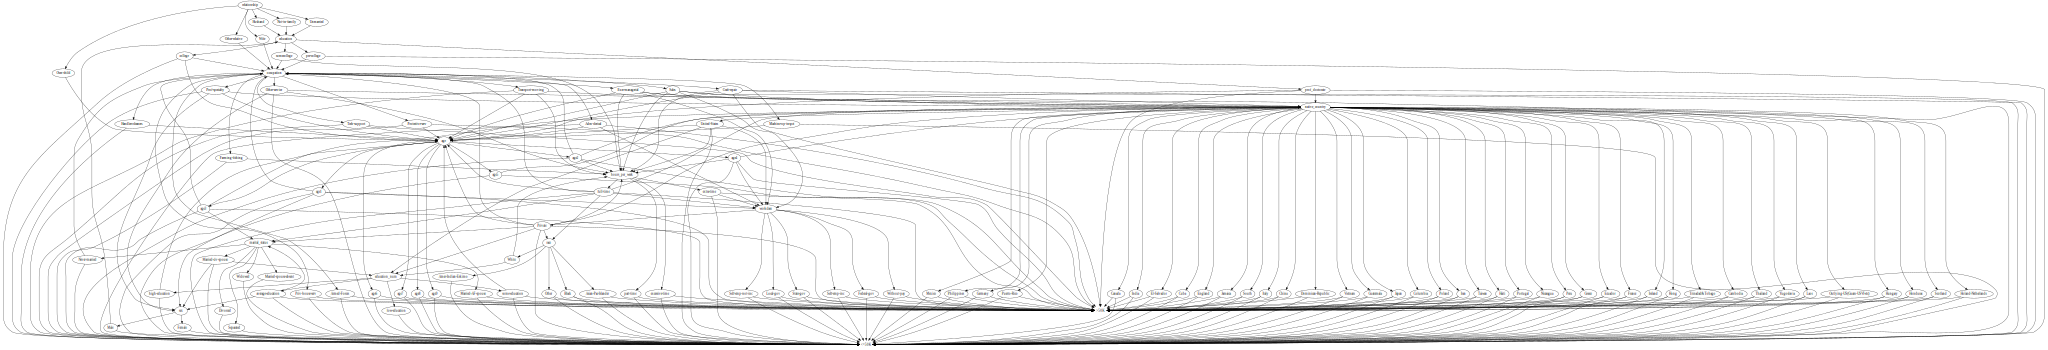

In [270]:
# Visual graph of dictionary as a tree
from graphviz import Digraph

def draw_decision_tree_dictionary(tree_dictionary):
    if not isinstance(tree_dictionary, dict):
        raise TypeError("Argument tree_dictinary must be of type dictionary")
    if not tree_dictionary:
        raise ValueError("Dictionary tree_dictionary is empty")
    dot = Digraph(strict=True)
    draw_tree(dot, tree_dictionary, None)
    return dot

def draw_tree(dot, tree_dictionary, parent_node_name):
    if isinstance(tree_dictionary, dict):
        for key in tree_dictionary:
            no_spaces_key = str(key).replace(" ", "")
            dot.node(no_spaces_key, str(key), shape="ellipse")
            if parent_node_name is not None :
                dot.edge(parent_node_name, no_spaces_key)
            draw_tree(dot, tree_dictionary[key], no_spaces_key)
    else:
        val = str(tree_dictionary)
        dot.node(val, val, shape="plaintext")
        dot.edge(parent_node_name, val)

print(decision_tree)
draw_decision_tree_dictionary(decision_tree)


